In [1]:
# Datalab - Laboratorio de Análisis de Datos
# Computational modeling of biological systems
# Universidad Nacional de Colombia
# Francisco Gómez
# 2023

In [2]:
# Load libraries and utility functions
%matplotlib inline
import pandas as pd
pd.options.mode.chained_assignment = None
import networkx as nx
from operator import itemgetter, attrgetter
import matplotlib as mpl
import matplotlib.pyplot as plt
import operator
import datetime
import seaborn as sns
import numpy as np
import math
from sklearn import preprocessing


# Utility functions

# Print pairs of dictionary and values
def printSortValues(dc,nValues):
    labels = {};
    degcent_sorted = sorted(dc.items(), key=itemgetter(1), reverse=True)
    print('----------------------->>>')
    for key, value in degcent_sorted[0:nValues]:
        print("   > ", key, round(value, 4))
        labels[key] = key;
    return labels; 

# Print sorted values in a dictionary
def getSortValues(dc):
    labels = [];
    totalValue = 0;
    degcent_sorted = sorted(dc.items(), key=itemgetter(1), reverse=True)
    
    for key, value in degcent_sorted[0:len(dc)]:
        totalValue = totalValue + value;        
        labels.append(key);
            
    return labels;

# Return a list of dictionary values
def getValues(dc):    
    valuesList = [];
    degcent_sorted = sorted(dc.items(), key=itemgetter(1), reverse=True)    
    for key, value in degcent_sorted[0:len(dc)]:        
        valuesList.append(value)
    return valuesList;

# Load animal movement data

Load the animal movement data at the interior of the department of Cesar (Colombia).

In [3]:
# Region name
nameDep = "CESAR"

# load the movilization data
df = pd.read_excel('data/data_mov.xlsx', sheet_name='movdata')

# Define origin and destination
nameDepOrigin = [nameDep];
nameDepDestiny = [nameDep];

# Filter movements at the interior of the region
df = df.loc[(df['DEPARTAMENTO_ORIGEN'].isin(nameDepOrigin)) & df['DEPARTAMENTO_DESTINO'].isin(nameDepDestiny)]

# Composed key with the type and the town
df['MUNICIPIO_ORIGEN-TIPO_ORIGEN'] = df['MUNICIPIO_ORIGEN']+'_'+df['TIPO_ORIGEN']
df['MUNICIPIO_DESTINO-TIPO_DESTINO'] = df['MUNICIPIO_DESTINO']+'_'+df['TIPO_DESTINO']

# Compute municipality list
listAllMuni = list(set(df['MUNICIPIO_DESTINO-TIPO_DESTINO'].values.tolist()).union(set(df['MUNICIPIO_ORIGEN-TIPO_ORIGEN'].values.tolist())))
listAllMuniFull = list(set(df['MUNICIPIO_ORIGEN'].values.tolist()).union(set(df['MUNICIPIO_DESTINO'].values.tolist())))

# Remove PLANTA DE BENEFICIO
print('Movements with sacrifice plants: '+str(len(df)))
df = df[df['TIPO_DESTINO']!='PLANTA DE BENEFICIO']

# Considers only movilizations between different towns
df = df[df['MUNICIPIO_ORIGEN']!=df['MUNICIPIO_DESTINO']]

# Total number animals movilizations for the period
df['TotalAnimals'] = df.iloc[:, 11:].sum(axis=1)

print('Movements without sacrifice plants: '+str(len(df)))
print('Destination types:')
print(df['TIPO_DESTINO'].unique())
print('Number of towns:')
print(len(df['MUNICIPIO_DESTINO'].unique()))
print('Number of nodes considered:')
print(len(df['MUNICIPIO_ORIGEN-TIPO_ORIGEN'].unique()))
print('Total number of animals:')
print(df['TotalAnimals'].sum())
print('Type of movement:')
print(df['TIPO_TRANSPORTE'].value_counts(normalize=True) * 100)

df['month'] = df['FECHA_CREO']
    

# Display the first 5 destinations
df.head(5)

Movements with sacrifice plants: 21254
Movements without sacrifice plants: 9854
Destination types:
['PREDIO' 'CONCENTRACION GANADERA']
Number of towns:
25
Number of nodes considered:
29
Total number of animals:
175068.0
Type of movement:
A CARRO    96.925107
A PIE       3.074893
Name: TIPO_TRANSPORTE, dtype: float64


,NOMBRE_OFICINA,DEPARTAMENTO_ORIGEN,MUNICIPIO_ORIGEN,TIPO_ORIGEN,DEPARTAMENTO_DESTINO,MUNICIPIO_DESTINO,TIPO_DESTINO,ESPECIE,FECHA_CREO,TIPO_TRANSPORTE,...,'HEMBRA BUFALINA DE 3 A 8 MESE,'HEMBRA BUFALINA ENTRE 8 Y 12,'MACHO BUFALINO MENORES DE 1 A,'MACHO BUFALINO DE 1 A 2 ANOS','MACHO BUFALINO DE 2 A 3 ANOS','MACHO BUFALINO MAYORES A 3 AN,MUNICIPIO_ORIGEN-TIPO_ORIGEN,MUNICIPIO_DESTINO-TIPO_DESTINO,TotalAnimals,month
4,VALLEDUPAR,CESAR,VALLEDUPAR,PREDIO,CESAR,BOSCONIA,PREDIO,BOVINA,2016-01-04,A CARRO,...,NaN,NaN,NaN,NaN,NaN,NaN,VALLEDUPAR_PREDIO,BOSCONIA_PREDIO,11.0,2016-01-04
7,CHIRIGUANA,CESAR,CHIRIGUANÁ,PREDIO,CESAR,CHIMICHAGUA,PREDIO,BOVINA,2016-01-04,A CARRO,...,NaN,NaN,NaN,NaN,NaN,NaN,CHIRIGUANÁ_PREDIO,CHIMICHAGUA_PREDIO,16.0,2016-01-04
16,AGUACHICA,CESAR,LA GLORIA,PREDIO,CESAR,GAMARRA,PREDIO,BOVINA,2016-01-04,A CARRO,...,NaN,NaN,NaN,NaN,NaN,NaN,LA GLORIA_PREDIO,GAMARRA_PREDIO,5.0,2016-01-04
18,PAILITAS,CESAR,PAILITAS,PREDIO,CESAR,BOSCONIA,PREDIO,BOVINA,2016-01-04,A CARRO,...,NaN,NaN,NaN,NaN,NaN,NaN,PAILITAS_PREDIO,BOSCONIA_PREDIO,23.0,2016-01-04
34,BOSCONIA,CESAR,EL PASO,PREDIO,CESAR,VALLEDUPAR,PREDIO,BOVINA,2016-01-04,A CARRO,...,NaN,NaN,NaN,NaN,NaN,NaN,EL PASO_PREDIO,VALLEDUPAR_PREDIO,14.0,2016-01-04


# Ranking of superspreaders municipalities

In [4]:
# Plot the graph associated to degree for the feature of interest
def plotFigureGraph(G,feature,nodes):
    plt.figure(figsize=(20,20))    
    pos = nx.spring_layout(G)
    labels = printSortValues(feature,10);
    nx.draw_networkx_nodes(G,pos,node_size=[v * 300 for v in feature.values()])
    nx.draw_networkx_labels(G,pos,labels,font_size=16,font_color='b')
    ax = plt.gca()
    ax.set_axis_off()    
    plt.show()

# Sort the borda list
def borda_sort(lists):
    scores = {};
    for l in lists:
        for idx, elem in enumerate(reversed(l)):
            if not elem in scores:
                scores[elem] = 0
            scores[elem] += idx
    return sorted(scores.keys(), key=lambda elem: scores[elem], reverse=True)
    
# Computes the centrality measures of a graph
# More centrally the nodes are located in the network, the greater spreading power they will have 6,13,14,15
# Dekker, A. H. (2013, December). Network centrality and super-spreaders in infectious disease epidemiology. In 20th International Congress on Modelling and Simulation (MODSIM2013).
# Computes different centrality measurements, in particular:

# Degree
# deg_cen -- Degree centrality: Fraction of nodes it is connected to
# in_deg_cen -- In degree centrality: Fraction of nodes its incoming edges are connected to
# out_deg_cen -- Out degree centrality: Fraction of nodes its outgoing edges are connected to

# deg_cen_weight -- Weighted node degree: Sum of the edge weights for edges incident to that node
# in_deg_cen_weight --  Weighted node in-degree: Sum of the edge weights for edges incident to that node
# out_deg_cen_weight --  Weighted node out-degree: Sum of the edge weights for edges pointing out of the node

# Betweenness
# bet_cen -- Betweenness centrality: Sum of the fraction of all-pairs shortest paths that pass through
# bet_cen_weight -- Weigthed betweenness centrality: Sum of the fraction of all-pairs shortest paths that pass through considering the weigths
def centralityMeasures(G,nValues,diplayInfo=False): 
    listFeaturesCentrality = [];
    if diplayInfo==True:
        print('--------------------------------------------------------------')
        print('CENTRALITY: identify the most important vertices within a graph')
        print('--------------------------------------------------------------')
        print('--------------------------------------------------------------')
    
    # Degree centrality
    deg_cen = nx.degree_centrality(G)
    if diplayInfo==True:
        print('-------->Degree centrality: Fraction of nodes it is connected to (weigths doesn\'t matter)\nImmediate risk of a node for catching whatever is flowing through the network (such as a virus, or some information)')
        print('-------->node’s degree represents the number of direct contacts per holding')
        print('-------->High-degree nodes are likely to become infected early on in an epidemic event')
        printSortValues(deg_cen,nValues)
    
    # This measurment if considered for the ranking because is predictor of super-spreading
    # Dekker, A. H. (2013, December). Network centrality and super-spreaders in infectious disease epidemiology. In 20th International Congress on Modelling and Simulation (MODSIM2013)
    listFeaturesCentrality.append(getSortValues(deg_cen));
    
    if G.is_directed() == True:    
        in_deg_cen = nx.in_degree_centrality(G)
        if diplayInfo==True:
            print('Degree centrality: Input version')
            printSortValues(in_deg_cen,nValues)
        
        # This measurment if considered for the ranking because is predictor of super-spreading
        # Dekker, A. H. (2013, December). Network centrality and super-spreaders in infectious disease epidemiology. In 20th International Congress on Modelling and Simulation (MODSIM2013).
        listFeaturesCentrality.append(getSortValues(in_deg_cen));

        out_deg_cen = nx.out_degree_centrality(G)
        if diplayInfo==True:
            print('Degree centrality: Output version')
            printSortValues(out_deg_cen,nValues)
        
        # This measurment if considered for the ranking because is predictor of super-spreading
        # Dekker, A. H. (2013, December). Network centrality and super-spreaders in infectious disease epidemiology. In 20th International Congress on Modelling and Simulation (MODSIM2013).
        listFeaturesCentrality.append(getSortValues(out_deg_cen));
    
    if diplayInfo==True:
        print('--------------------------------------------------------------')
        print('Degree centrality: Weigthed version')
    
    deg_cen_weight = {node:val for (node, val) in G.degree(weight='TotalAnimals')};
    
    if diplayInfo==True:
        printSortValues(deg_cen_weight,nValues)
    
    # This measurment if considered for the ranking because is predictor of super-spreading
    # Dekker, A. H. (2013, December). Network centrality and super-spreaders in infectious disease epidemiology. In 20th International Congress on Modelling and Simulation (MODSIM2013).
    listFeaturesCentrality.append(getSortValues(deg_cen_weight));

    if G.is_directed() == True:
        in_deg_cen_weight = {node:val for (node, val) in G.in_degree(weight='TotalAnimals')};
        if diplayInfo==True:
            print('Degree centrality: Weigthed input version')
            printSortValues(in_deg_cen_weight,nValues)
        
        # This measurment if considered for the ranking because is predictor of super-spreading
        # Dekker, A. H. (2013, December). Network centrality and super-spreaders in infectious disease epidemiology. In 20th International Congress on Modelling and Simulation (MODSIM2013).
        listFeaturesCentrality.append(getSortValues(in_deg_cen_weight));
        
        out_deg_cen_weight = {node:val for (node, val) in G.out_degree(weight='TotalAnimals')};
        if diplayInfo==True:
            print('Degree centrality: Weigthed output version')        
            printSortValues(out_deg_cen_weight,nValues)
        
        # This measurment if considered for the ranking because is predictor of super-spreading
        # Dekker, A. H. (2013, December). Network centrality and super-spreaders in infectious disease epidemiology. In 20th International Congress on Modelling and Simulation (MODSIM2013).
        listFeaturesCentrality.append(getSortValues(out_deg_cen_weight));

    if diplayInfo==True:        
        print('--------------------------------------------------------------')        
        print('--------------------------------------------------------------')

    # Betweenness centrality
    bet_cen = nx.betweenness_centrality(G)
    
    if diplayInfo==True:
        print('-------->Betweenness centrality: (The node is a bridge?)\nSum of the fraction of all-pairs shortest paths that pass through v (weigths doesn\'t matter)')
        print('-------->betweenness of a node represents the frequency with which a livestock holding is in the shortest path between pairs of nodes in the network')
        print('-------->high-betweenness nodes are likely to accelerate the spread of infection through the network')
        printSortValues(bet_cen,nValues)
    
    # This measurment if considered for the ranking because is predictor of super-spreading
    # Dekker, A. H. (2013, December). Network centrality and super-spreaders in infectious disease epidemiology. In 20th International Congress on Modelling and Simulation (MODSIM2013).
    listFeaturesCentrality.append(getSortValues(bet_cen));
    
    # Betweenness centrality
    bet_cen_weight = nx.betweenness_centrality(G,weight='TotalAnimals')

    if diplayInfo==True:        
        print('Betweenness centrality: Weigthed version')
        printSortValues(bet_cen_weight,nValues)
    
    # This measurment if considered for the ranking because is predictor of super-spreading
    # Dekker, A. H. (2013, December). Network centrality and super-spreaders in infectious disease epidemiology. In 20th International Congress on Modelling and Simulation (MODSIM2013).
    listFeaturesCentrality.append(getSortValues(bet_cen_weight));
    
    
    #### MORE MEASURMENTS BASED ON:
    ##   Spatio-temporal network analysis of pig trade to inform the design of risk-based disease surveillance
    # closeness centrality
    
    closs_cen_weight = nx.closeness_centrality(G)
    if diplayInfo==True:        
        print('Closeness centrality: Weigthed version')
        printSortValues(closs_cen_weight,nValues)        
    listFeaturesCentrality.append(getSortValues(closs_cen_weight));

    
    
    closs_cen_weight = nx.closeness_centrality(G)
    if diplayInfo==True:        
        print('Closeness centrality: Weigthed version')
        printSortValues(closs_cen_weight,nValues)        
    listFeaturesCentrality.append(getSortValues(closs_cen_weight));

    pr = nx.pagerank(G)    
    if diplayInfo==True:        
        print('Pagerank')
        printSortValues(pr,nValues)        
    
    listFeaturesCentrality.append(getSortValues(pr));
    
    
    # return the list of centrality measurments
    return (listFeaturesCentrality,[getValues(deg_cen),
                                    getValues(in_deg_cen),
                                    getValues(out_deg_cen),
                                    getValues(deg_cen_weight),
                                    getValues(in_deg_cen_weight),
                                    getValues(out_deg_cen_weight),
                                    getValues(bet_cen),
                                    getValues(bet_cen_weight),
                                    getValues(closs_cen_weight),
                                    getValues(pr)],
           [deg_cen,
            in_deg_cen,
            out_deg_cen,
            deg_cen_weight,
            in_deg_cen_weight,
            out_deg_cen_weight,
            bet_cen,
            bet_cen_weight,
            closs_cen_weight,
            pr]);


# Computes the superspreaders based on the centrality measurments
# Super-spreaders are the nodes of a network that can maximize their impacts on other nodes
# This superspreader list is construted by hierarchical aggregation of degree and betweeness
# Madotto, A., & Liu, J. (2016). Super-spreader identification using meta-centrality. Scientific reports, 6(1), 1-10.
def superSpreadersNodes(G,diplayInfo=False):
    sortBordaSuperSpreaders = []
    listFeatures = []
    if len(G.nodes())>0:
        nvalues = 5
        
        # Computes the centrality measurements
        (features,listFeaturesSorted,listFeatures) = centralityMeasures(G,nvalues,diplayInfo)

        # Computes a hierarchical borda aggregation
        if G.is_directed() == True:
            # Borda aggregation for degree
            #sortDegree = borda_sort(features[0])
            #sortDegree = borda_sort(features[0:5])
            sortDegree = borda_sort(features[0:5])
            # Borda aggregation for betweeness
            sortBetween = borda_sort(features[6:8])
        
        else:
            # Borda aggregation for degree
            sortDegree = borda_sort(features[0:1])
            # Borda aggregation for betweeness
            sortBetween = borda_sort(features[2:3])            

        # Complete Borda sort for each feature
        sortBordaSuperSpreaders = borda_sort([list(sortDegree),list(sortBetween)])
        # Uncomment for rankings based only on Degree
        #sortBordaSuperSpreaders = borda_sort([list(sortDegree)])
        # Uncomment for rankings based only on Betweeness
        #sortBordaSuperSpreaders = borda_sort([list(sortBetween)])
        
    else:
        print('--->Empty graph')
    
    # Return the borda aggregation results
    return (sortBordaSuperSpreaders,listFeaturesSorted,listFeatures);
    

def plotScaleFree(graph):
    k = []
    Pk = []
    logk = [];
    logPk = [];
    for node in list(graph.nodes()):
        degree = graph.degree(nbunch=node)
        try:
            pos = k.index(degree)
        except ValueError as e:
            k.append(degree)
            Pk.append(1)
        else:
            Pk[pos] += 1

    # get a double log representation
    for i in range(len(k)):
        logk.append(math.log10(k[i]))
        logPk.append(math.log10(Pk[i]))

    order = np.argsort(logk)
    logk_array = np.array(logk)[order]
    logPk_array = np.array(logPk)[order]
    #plt.plot(logk_array, logPk_array, ".")
    #m, c = np.polyfit(logk_array, logPk_array, 1)    
    #plt.plot(logk_array, m*logk_array + c, "-")   
    
    logk_interp = np.linspace(np.min(logk_array),np.max(logk_array),1000)
    logPk_interp = np.interp(logk_interp, logk_array, logPk_array)
    plt.plot(logk_array, logPk_array,".")

    m, c = np.polyfit(logk_interp, logPk_interp, 1)
    print("---------------------------->"+str(m))
    plt.plot(logk_interp, m*logk_interp + c, "-")    

# Computes the list of superspreaders
def getSuperSpreadersNodes(df1):
    
    # Total number animals movilizations for the period
    df1['TotalAnimals'] = df1.iloc[:, 11:].sum(axis=1)
            
    # Construct a weigthed directed graph between the different municipalities using the total number of animals movilized as weigth
    # Mohr, S., Deason, M., Churakov, M., Doherty, T., & Kao, R. R. (2018). Manipulation of contact network structure and the impact on foot-and-mouth disease transmission. Preventive veterinary medicine, 157, 8-18.
    G = nx.from_pandas_edgelist(df1,source='MUNICIPIO_ORIGEN-TIPO_ORIGEN',target='MUNICIPIO_DESTINO-TIPO_DESTINO',edge_attr=('TotalAnimals','FECHA_CREO'),create_using=nx.DiGraph());  

    # Computes the ranking of the superspreader nodes for the graph
    rankTowns,listFeaturesSorted,listFeatures = superSpreadersNodes(G);

    return (rankTowns,listFeaturesSorted,listFeatures,G);
    

# Computes a normalized index based on 
# Spatio-temporal network analysis of pig trade to inform the design of risk-based disease surveillance
def getNormRiskIndex(lf):
    listFeaturesMun = []
    for i in range(len(lf)):
        k = 0
        for itemVal in lf[i].items():
            values = lf[i].items()
            if i==0:
                listFeaturesMun.append([itemVal[0]])
            listFeaturesMun[k].append(itemVal[1])
            k = k + 1

    dfT = pd.DataFrame(listFeaturesMun,columns =['Names','deg_cen','in_deg_cen','out_deg_cen','deg_cen_weight','in_deg_cen_weight','out_deg_cen_weight','bet_cen','bet_cen_weight','closs_cen_weight','pr'])
    column_names_to_normalize = ['deg_cen','in_deg_cen','out_deg_cen','deg_cen_weight','in_deg_cen_weight','out_deg_cen_weight','bet_cen','bet_cen_weight','closs_cen_weight','pr']
    x = dfT[column_names_to_normalize].values
    min_max_scaler = preprocessing.MinMaxScaler()

    x_scaled = min_max_scaler.fit_transform(x)
    df_temp = pd.DataFrame(x_scaled, columns=column_names_to_normalize, index = dfT.index)
    df_temp = df_temp[['deg_cen']]
    dfT['riskIndex']=(df_temp.sum(axis=1)/df_temp.sum(axis=1).max())
    dfT = dfT.sort_values('riskIndex',ascending=False)
    return dfT['Names'].values.tolist()
    
    
# Year under study
year = 2016

# Size of the aggregation window, four weeks
timePeriod = 30;

# Non-overlapped windows
slicingTime = 30;

# Convert time format
df['FECHA_CREO'] = pd.to_datetime(df['FECHA_CREO'])

# Empty dataframe to store variables related to the network analysis
dfR = pd.DataFrame(columns=['Period','Period Start','Period End','Number Registers', 'Total Degree Value', 'Average Degree Value','GSCC'])
dfR['Period'] = pd.to_numeric(dfR['Period'])
dfR['Total Degree Value'] = pd.to_numeric(dfR['Total Degree Value'])
dfR['Average Degree Value'] = pd.to_numeric(dfR['Average Degree Value'])
dfR['GSCC'] = pd.to_numeric(dfR['GSCC'])

# Months list
months = ["January","February","March","April","May","June","July","August","September","October","November","December"];
timePeriods = []

for i in range(12):
    timePeriods.append(months[i])



i = 1;

monthlyRanks = [];
listFeaturesPeriods = [];

dataNetworkDistribution = []

for monthYear in range(1,13):
    # Filters by month of the year
    dfp = df[df['FECHA_CREO'].dt.month==monthYear]    
    # Computes the superspreaders nodes
    (sortBordaSuperSpreaders,listFeatures,lf,GTest) = getSuperSpreadersNodes(dfp)
    # Get network data distribution
    dataNetworkDistribution.append(listFeatures)
    
    listFeaturesPeriods.append(listFeatures)

    # Add towns in which there were no movements at the end of the ranking
    listMunNoMov = list(set(listAllMuni).symmetric_difference(set(sortBordaSuperSpreaders)))
    # Add towns in alphabetic order
    listMunNoMov.sort()
    sortBordaSuperSpreaders = sortBordaSuperSpreaders + listMunNoMov

    # Store the final ranking
    monthlyRanks.append(sortBordaSuperSpreaders)
    
# Creates a dataframe with the monthly rank
dfRankSuperspreaders = pd.DataFrame(list(map(list, zip(*monthlyRanks))),columns=timePeriods)

# Print the top five of superspreader towns per month

dfRankSuperspreaders.to_csv('rankingSuper'+nameDep+'.csv')
dfRankSuperspreaders.head(5)


,January,February,March,April,May,June,July,August,September,October,November,December
0,AGUSTÍN CODAZZI_PREDIO,VALLEDUPAR_PREDIO,VALLEDUPAR_PREDIO,VALLEDUPAR_PREDIO,VALLEDUPAR_PREDIO,VALLEDUPAR_PREDIO,SAN MARTÍN_PREDIO,SAN ALBERTO_PREDIO,VALLEDUPAR_PREDIO,VALLEDUPAR_PREDIO,CURUMANÍ_PREDIO,VALLEDUPAR_PREDIO
1,CURUMANÍ_PREDIO,PAILITAS_PREDIO,PAILITAS_PREDIO,SAN MARTÍN_PREDIO,SAN MARTÍN_PREDIO,AGUSTÍN CODAZZI_PREDIO,VALLEDUPAR_PREDIO,VALLEDUPAR_PREDIO,BOSCONIA_PREDIO,SAN MARTÍN_PREDIO,PAILITAS_PREDIO,TAMALAMEQUE_PREDIO
2,PAILITAS_PREDIO,SAN DIEGO_PREDIO,BECERRIL_PREDIO,AGUACHICA_PREDIO,SAN ALBERTO_PREDIO,SAN ALBERTO_PREDIO,PAILITAS_PREDIO,SAN DIEGO_PREDIO,SAN DIEGO_PREDIO,CHIMICHAGUA_PREDIO,CHIMICHAGUA_PREDIO,PELAYA_PREDIO
3,BOSCONIA_PREDIO,BECERRIL_PREDIO,LA PAZ_PREDIO,CHIMICHAGUA_PREDIO,SAN DIEGO_PREDIO,CURUMANÍ_PREDIO,LA GLORIA_PREDIO,TAMALAMEQUE_PREDIO,PAILITAS_PREDIO,PELAYA_PREDIO,VALLEDUPAR_PREDIO,SAN DIEGO_PREDIO
4,PELAYA_PREDIO,CHIMICHAGUA_PREDIO,AGUACHICA_PREDIO,CHIRIGUANÁ_PREDIO,CHIRIGUANÁ_PREDIO,BECERRIL_PREDIO,CURUMANÍ_PREDIO,CURUMANÍ_PREDIO,CURUMANÍ_PREDIO,CURUMANÍ_PREDIO,BECERRIL_PREDIO,SAN MARTÍN_PREDIO


Stats for Degree:
Skew:-0.2931087960214551+/-0.29144304048874153
Kurtosis:0.9669811804026347+/-0.6611606870687696

Stats for In degree:
Skew:-0.08332654101976247+/-0.2571786693804134
Kurtosis:-0.05391269061244116+/-0.6680102129157919

Stats for Out degree:
Skew:0.565788830288208+/-0.4074030080734864
Kurtosis:1.493724126752524+/-1.152738969013888

Stats for Weigthed degree:
Skew:0.17663788754833698+/-0.6510751980433179
Kurtosis:0.5995844205378408+/-1.3721021646769138

Stats for In weigthed degree:
Skew:0.7539609982755308+/-0.8118008117179176
Kurtosis:1.5213809066593453+/-2.7864708540381926

Stats for Out weigthed degree:
Skew:0.9855140673209578+/-0.7762340960475819
Kurtosis:2.0806451134892203+/-3.3468773767334294

Stats for Betweenness:
Skew:1.833825471705081+/-0.5987392283600645
Kurtosis:4.213778763595698+/-3.0318535077499473

Stats for Weigthed betweenness:
Skew:1.3096295877115922+/-0.3779574473854323
Kurtosis:1.6035345290131084+/-1.7851291803557736



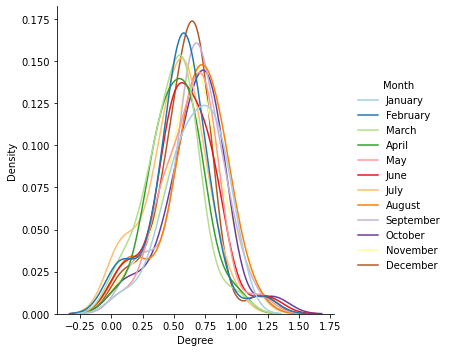

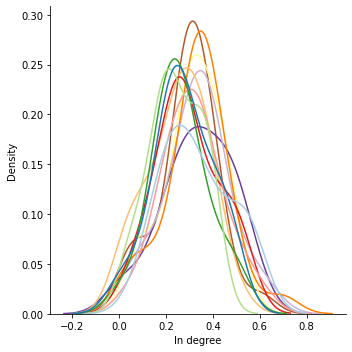

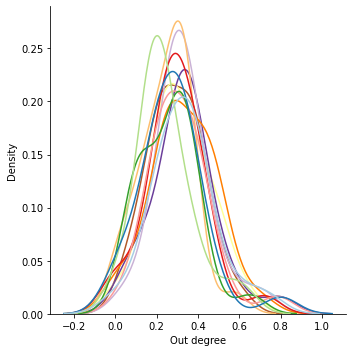

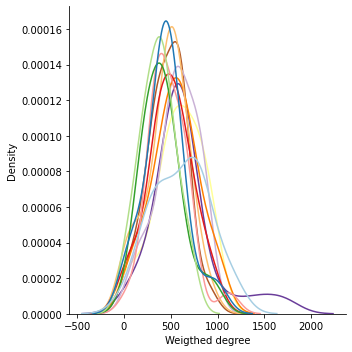

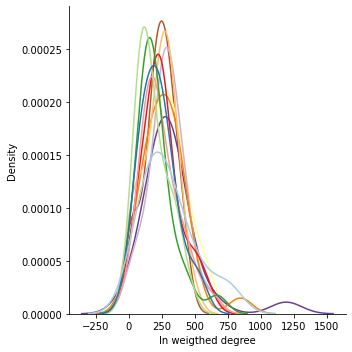

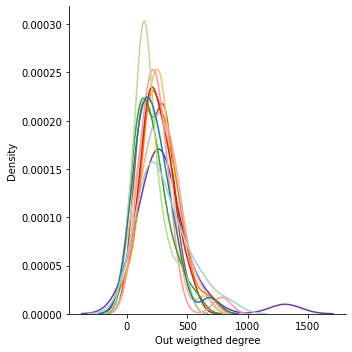

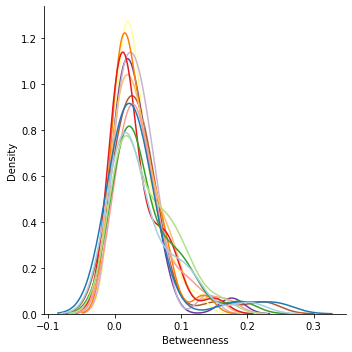

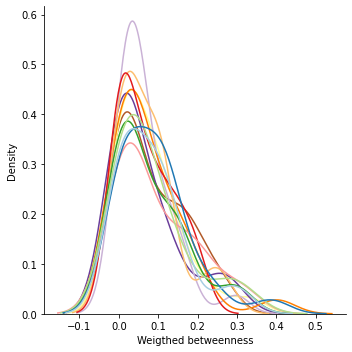

In [5]:
featureNames = []
tableDataDistribution = [];
iIndex = 0
featureNames = ['Degree','In degree','Out degree','Weigthed degree','In weigthed degree','Out weigthed degree','Betweenness','Weigthed betweenness']

for imonth in range(len(dataNetworkDistribution)):
    for ifeat  in range(len(dataNetworkDistribution[imonth])):
        for ival in range(len(dataNetworkDistribution[imonth][ifeat])):
            tableDataDistribution.append([months[imonth],ifeat,dataNetworkDistribution[imonth][ifeat][ival]])
            iIndex = iIndex + 1


dfValFeat = pd.DataFrame(tableDataDistribution,columns = ['Month','Feature','Value'])


for ifeatVal in range(8):
    dfValFeat0 = dfValFeat.loc[dfValFeat['Feature'] == ifeatVal]
    if ifeatVal == 0:
        valLegend = True
    else:
        valLegend = False
    
    distPlot = sns.displot(dfValFeat0, x="Value", palette='Paired', hue="Month", kind="kde",legend=valLegend)
    
    skewVec = []
    kurtosisVec = []
    for ivalMonth in dfValFeat0['Month'].unique():
        dfValMonth = dfValFeat0[dfValFeat0['Month']==ivalMonth]
        skewVec.append(dfValMonth['Value'].astype(float).skew())
        kurtosisVec.append(dfValMonth['Value'].astype(float).kurtosis())
    
    
    print('Stats for '+featureNames[ifeatVal]+':')
    print('Skew:'+str(np.mean(skewVec))+'+/-'+str(np.std(skewVec)))
    print('Kurtosis:'+str(np.mean(kurtosisVec))+'+/-'+str(np.std(kurtosisVec))+'\n')
    
    distPlot.set(xlabel = featureNames[ifeatVal])
    sns.set_palette("rocket")
    plt.savefig('figuresDistribution/dist_' + featureNames[ifeatVal]+'.png')


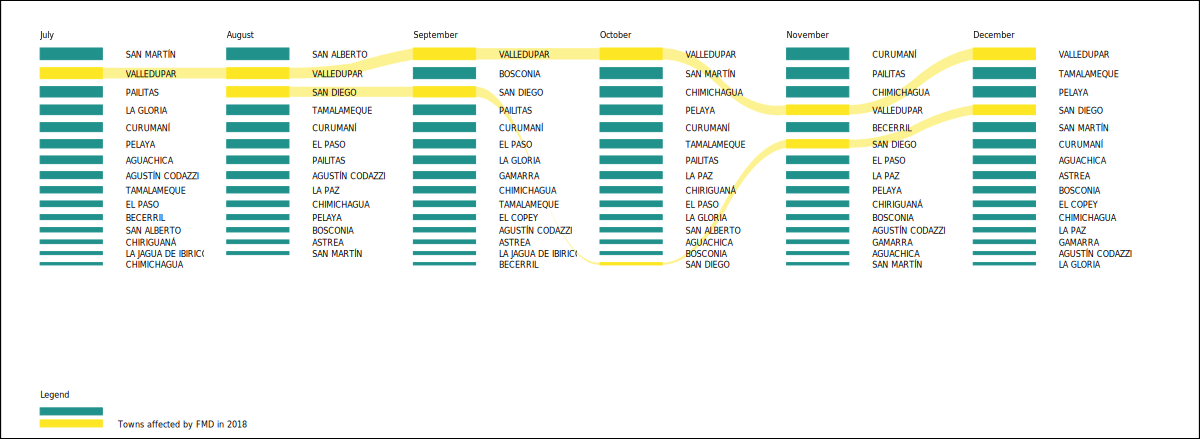

In [6]:
from visualizationrank import visualizeRank
import pycatflow as pcf

import os

# Compute a ranking structure for data visualization
def getRankedItems(months,mun_fmd,rangeMonths,munList,topRankValue):
    tempFileCSV = '_dataRank.csv'
    listMunRankDup = []
    topRank = topRankValue
    for i in rangeMonths:
        munList = monthlyRanks[i]
        listNumTop = []
        for j in range(len(munList)):
            m = munList[j]
            dataMunSplt = m.split('_')
            nameNum = dataMunSplt[0]
            typeProd = ''
            if nameNum in mun_fmd:
                typeProd = 'Towns affected by FMD in 2018'
            for dup in range(topRank-j):
                listMunRankDup.append([months[i],nameNum,typeProd,i+1])
            if topRank == j:
                break

    dfRankDup = pd.DataFrame(listMunRankDup,columns=["column","items","category","column order"])
    dfRankDup.to_csv(tempFileCSV,index=False)
    data = pcf.read_file(tempFileCSV, columns="column", nodes="items", categories="category", column_order="column order")
    os.remove(tempFileCSV)
    
    d = {}
    for item in data.items():
        if type(item[1][next(iter(item[1]))]) == tuple:
            rankVal = topRankValue
            for k, v in item[1].items():
                if rankVal==topRankValue:
                    d[item[0]] = {k:(rankVal,v[1])}
                else:
                    d[item[0]].update({k:(rankVal,v[1])})
                rankVal = rankVal - 1
    
    return d

mun_fmd = ["VALLEDUPAR","SAN DIEGO"]

topRankValue = 15

# Uncomment for the ranking figure for the first semester 
#dataMod = getRankedItems(timePeriods,mun_fmd,range(0,6),monthlyRanks,topRankValue)
# Uncomment for the ranking figure for the second semester
dataMod = getRankedItems(timePeriods,mun_fmd,range(6,12),monthlyRanks,topRankValue)

viz = visualizeRank(dataMod, spacing=40, width=1200,
                  color_startEnd=False,
                  color_categories=True,
                  start_node_color='red',
                  nodes_color='blue',
                  connection_type='curved',
                  node_size=.2,
                  sort_by='none',
                  show_labels=True,
                  label_size = 8,
                  label_shortening = 'clip',
                  category_noplot = '',
                  palette = ("viridis",3)                
                )
viz.savePng('figure__'+nameDep+'.png')
viz




# Classification using ranking performance

Computes the classification performance when characterizing an outbreak using the proposed ranking

Mean of Negative predictive values for binary classifiers 
constructed using the top three municipalities provided by the ranking
[0.66666667 0.41666667 0.36111111]
Std of Negative predictive values for binary classifiers 
constructed using the top three municipalities provided by the ranking
[0.47140452 0.186339   0.21336516]


<Figure size 468x432 with 0 Axes>

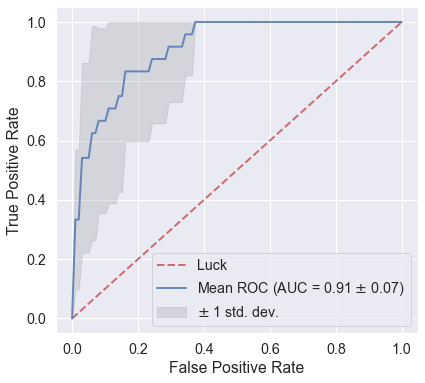

0.9122807017543858
0.06907024450887557
AUC for a rank based on animal density:
0.8947368421052632
AUC for a rank based on number of farms:
0.8026315789473684


In [7]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
import sklearn.metrics as metrics
from numpy import interp
import seaborn as sns

# https://www.biochemia-medica.com/en/journal/17/2/10.11613/BM.2007.014/fullArticle
def negativePreditiveValue(labels,thresh):
    npv = []
    for i in thresh:        
        pred = [2]*len(labels)
        for ii in range(i):
            pred[ii] =  1
        tn, fp, fn, tp = confusion_matrix(labels,pred).ravel()
        npv.append(tn/(tn+fn))
    return npv

sns.set_theme(style="white", palette=None)
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.set(font_scale = 1.3)

mun_fmd = ["VALLEDUPAR_PREDIO","SAN DIEGO_PREDIO"]

aucs = []
plt.figure(figsize=(6.5,6))

tprs = []
mean_fpr = np.linspace(0, 1, 100)

npvs = []

for imun in range(12):
    munAll = monthlyRanks[imun]
    # Computes the label of the municipality: 1-FMD, 2-No-FMD
    labelGTMun = []
    for i in munAll:
        # There was no FMD event
        fmdEvent = 2
        # Check if the municipality had a FMD event
        for j in mun_fmd:
            if i.find(j) != -1:
                fmdEvent = 1
                break
        
        labelGTMun.append(fmdEvent)
        
    # Computes the ROC curve for each month
    fpr, tpr, thresholds = metrics.roc_curve(labelGTMun,range(len(munAll),0,-1), pos_label=1)
    # Computes classifiers with the top 5 negative predictive values
    npv = negativePreditiveValue(labelGTMun,[1,2,3])
    npvs.append(npv)
    
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    # Computes the area under the ROC
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)


print("Mean of Negative predictive values for binary classifiers \nconstructed using the top three municipalities provided by the ranking")
print(np.mean(npvs, axis=0))
print("Std of Negative predictive values for binary classifiers \nconstructed using the top three municipalities provided by the ranking")
print(np.std(npvs, axis=0))
    
# Plot for the ROC curve
plt.figure(figsize=(6.5,6))

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

plt.savefig("ROCMonths.png")
plt.show()


# Print the area under the ROC for all months
print(np.mean(aucs))
print(np.std(aucs))

# Computes a fixed ranking based on the number of animals
def getAUCCensus(dfCensus,columnName):
    dfCensusSorted = dfCensus.sort_values(by=[columnName],ascending=False)
    # Creates the rank based on the order provided by the number of animals
    rankNumberAnimals = [2]*len(munAll)
    k = 0
    for iName in dfCensusSorted['MUNICIPIO']:
        if iName in mun_fmd:
            rankNumberAnimals[k] = 1
        k = k + 1
    fprNumberAnimals, tprNumberAnimals, thresholdAnimals = metrics.roc_curve(rankNumberAnimals,range(len(munAll),0,-1), pos_label=1)
    return auc(fprNumberAnimals, tprNumberAnimals)

dfCensus = pd.read_excel('data/cesar_census.xlsx', sheet_name='data')
# Computes density of animals
dfCensus['Animal Density']= dfCensus['TOTAL BOVINOS - 2018']/dfCensus['TOTAL BOVINOS - 2018'].sum()

print('AUC for a rank based on animal density:')
print(getAUCCensus(dfCensus,'Animal Density'))
print('AUC for a rank based on number of farms:')
print(getAUCCensus(dfCensus,'TOTAL FINCAS CON BOVINOS - 2018'))



In [22]:
# Export rankings
dfRanks = pd.DataFrame(np.array(monthlyRanks).T,'columns'=months)
dfRanks.head(15).to_excel("MontlyRanks.xls")

SyntaxError: keyword can't be an expression (<ipython-input-22-d4903a7e339d>, line 2)

# Stability between ranks

Computes stability between monthly ranks using Spearman's rank correlation coefficient

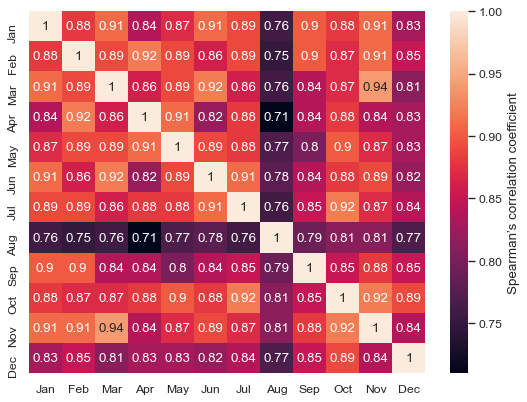

In [10]:
import numpy

sns.set_theme(style="white", palette=None)
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.set(font_scale = 1)


ranksIndex = []
for imun in range(12):
    munAll = monthlyRanks[imun]
    ranksIndex.append(numpy.argsort(munAll))
from scipy import stats

spearCorr = []

for iv in range(12):
    spearRow = []
    for jv in range(12):
        #if iv!=jv:
        if len(ranksIndex[iv])==len(ranksIndex[jv]):
            valSpear,pValSpear = np.round(stats.spearmanr(ranksIndex[iv],ranksIndex[jv]),2)
            spearRow.append(valSpear)
    spearCorr.append(spearRow)
    
dfCorr = pd.DataFrame(spearCorr, index =["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"],
                                              columns =["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])

plt.figure(figsize=(8, 6), dpi=80)
ax = sns.heatmap(dfCorr, annot=True)
ax.collections[0].colorbar.set_label("Spearman’s correlation coefficient")

plt.savefig("SimilarityMonths.png")
plt.show()
